In [3]:
from rastervision.core.data import RasterioSource, GeoJSONVectorSource, RasterioCRSTransformer,BufferTransformer,RasterizedSource, ClassInferenceTransformer
import tifffile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import rasterio
from osgeo import gdal
import torch
import os
import os.path
import json
import cv2

In [2]:
#Setting environment variables for Rasterio
import os
from subprocess import check_output

os.environ['GDAL_DATA'] = check_output('pip show rasterio | grep Location | awk \'{print $NF"/rasterio/gdal_data/"}\'', shell=True).decode().strip()
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [4]:
BASE_IMAGE_FOLDER = '/home/ac18/Senior Design Project/Sentinel-2 2021-UAE'
all_images = ['file:///'+os.path.join(BASE_IMAGE_FOLDER,file) for file in os.listdir(BASE_IMAGE_FOLDER) if file.endswith('.tif')]
all_images.sort()
all_images

['file:////home/ac18/Senior Design Project/Sentinel-2 2021-UAE/MosaicImage.tif',
 'file:////home/ac18/Senior Design Project/Sentinel-2 2021-UAE/Sentinel-2_2021_UAE-0000000000-0000000000.tif',
 'file:////home/ac18/Senior Design Project/Sentinel-2 2021-UAE/Sentinel-2_2021_UAE-0000000000-0000016384.tif',
 'file:////home/ac18/Senior Design Project/Sentinel-2 2021-UAE/Sentinel-2_2021_UAE-0000000000-0000032768.tif',
 'file:////home/ac18/Senior Design Project/Sentinel-2 2021-UAE/Sentinel-2_2021_UAE-0000000000-0000049152.tif',
 'file:////home/ac18/Senior Design Project/Sentinel-2 2021-UAE/Sentinel-2_2021_UAE-0000016384-0000000000.tif',
 'file:////home/ac18/Senior Design Project/Sentinel-2 2021-UAE/Sentinel-2_2021_UAE-0000016384-0000016384.tif',
 'file:////home/ac18/Senior Design Project/Sentinel-2 2021-UAE/Sentinel-2_2021_UAE-0000016384-0000032768.tif',
 'file:////home/ac18/Senior Design Project/Sentinel-2 2021-UAE/Sentinel-2_2021_UAE-0000016384-0000049152.tif',
 'file:////home/ac18/Senior Des

In [5]:
vector_data = [os.path.join(BASE_IMAGE_FOLDER,file) for file in os.listdir(BASE_IMAGE_FOLDER) if file.endswith('.geojson')]

In [6]:
vector_data

['/home/ac18/Senior Design Project/Sentinel-2 2021-UAE/Verticez_Coords.geojson',
 '/home/ac18/Senior Design Project/Sentinel-2 2021-UAE/Vertices_16384_32768.geojson',
 '/home/ac18/Senior Design Project/Sentinel-2 2021-UAE/Vectorized_16384_32768.geojson']

In [47]:
vector_source.extent

Box(ymin=0, xmin=32769, ymax=16383, xmax=49150)

In [7]:
raster_tile_1 = RasterioSource(all_images[7],allow_streaming = False)
crs_transformer = RasterioCRSTransformer.from_uri(all_images[5])
vector_source = GeoJSONVectorSource(vector_data[-1], crs_transformer, ignore_crs_field=True,vector_transformers=[ClassInferenceTransformer(class_id_col_name='DN')])

In [8]:
raster_tile_1.shape

(16384, 16384, 4)

In [ ]:
import gc
del vector_source
gc.collect()

In [ ]:
print(all_images[4])
os.path.isfile(all_images[4])

In [8]:
vector_data = vector_source.get_geojson()

Simplifying polygons: 100%|███████████████| 78136/78136 [15:12<00:00, 85.62it/s]


In [ ]:
vector_source.get_dataframe()

In [45]:
vector_source._geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': (((34172.0, 0.0),
      (34172.0, 1.0),
      (34175.0, 1.0),
      (34175.0, 0.0),
      (34172.0, 0.0)),)},
   'properties': {'fid': 1, 'DN': 2, 'class_id': 2}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': (((34352.0, 0.0),
      (34352.0, 1.0),
      (34355.0, 1.0),
      (34355.0, 2.0),
      (34358.0, 2.0),
      (34358.0, 1.0),
      (34362.0, 1.0),
      (34362.0, 0.0),
      (34352.0, 0.0)),)},
   'properties': {'fid': 2, 'DN': 4, 'class_id': 4}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': (((34816.0, 0.0),
      (34816.0, 3.0),
      (34817.0, 3.0),
      (34817.0, 4.0),
      (34854.0, 4.0),
      (34854.0, 3.0),
      (34855.0, 3.0),
      (34855.0, 2.0),
      (34856.0, 2.0),
      (34856.0, 0.0),
      (34816.0, 0.0)),)},
   'properties': {'fid': 3, 'DN': 1, 'class_id': 1}},
  {'type': 'Featur

In [ ]:
for i in range(len(vector_source._geojson['features'])):
    vector_source._geojson['features'][i]['properties']['class_id'] = vector_source._geojson['features'][i]['properties'].pop('DN')


In [ ]:
vector_data

In [9]:
def plot_geoms(geoms: list, title=''):
    from matplotlib import pyplot as plt
    from matplotlib import patches as patches
    import numpy as np

    fig, ax = plt.subplots(figsize=(5, 5))
    for g in geoms:
        if g.geom_type == 'Polygon':
            xy = np.array(g.exterior)
            patch = patches.Polygon(xy, color='#55cc77', alpha=0.5)
            ax.add_patch(patch)
            patch = patches.Polygon(xy, edgecolor='#005511', fill=None, alpha=1)
            ax.add_patch(patch)
        elif g.geom_type == 'LineString':
            xy = np.array(g.buffer(1).exterior)
            patch = patches.Polygon(xy, color='#005511', alpha=0.8)
            ax.add_patch(patch)
        else:
            raise NotImplementedError()
    ax.set_title(title, fontsize=14)
    ax.autoscale()
    plt.show()

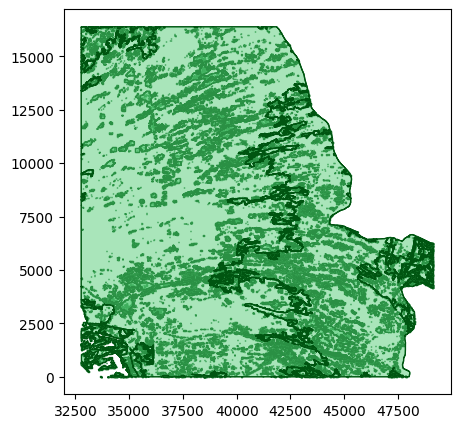

In [10]:
geoms = vector_source.get_geoms()
plot_geoms(geoms)

In [9]:
rasterized_source = RasterizedSource(
    vector_source,
    background_class_id=0,
    # Normally we'd pass in the RasterSource's extent, but we don't have that here.
    extent=vector_source.extent)

In [11]:
rasterized_source.shape

(16383, 16381, 1)

In [87]:
type(raster_tile_1)

rastervision.core.data.raster_source.rasterio_source.RasterioSource

In [12]:
rasterized_source = cv2.resize(rasterized_source.get_image_array(), dsize = (raster_tile_1.shape[0],raster_tile_1.shape[1]), interpolation = cv2.INTER_LINEAR)
rasterized_source.shape 

(16384, 16384)

In [13]:
rasterized_source = np.expand_dims(rasterized_source, axis=-1)
rasterized_source.shape

(16384, 16384, 1)

In [70]:
i=30
chip_vector_raster = rasterized_source.get_image_array()
chip_max = chip.reshape(-1,chip.shape[-1]).max(axis=0)
chip_min = chip.reshape(-1,chip.shape[-1]).min(axis=0)
chip.shape

(400, 400, 3)

In [71]:
chip_vector_raster.shape


(16383, 16381, 1)

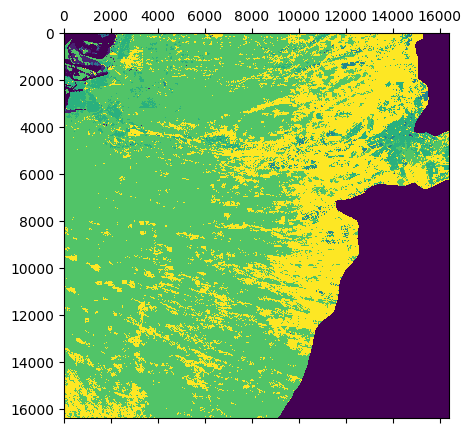

In [72]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(chip_vector_raster)
plt.show()

In [14]:
chip = raster_tile_1.get_image_array()[:,:,[2,1,0]] #Image is BGR, Convert to RGB before displaying
#Chip needs to be normalized
chip_max = chip.reshape(-1,chip.shape[-1]).max(axis=0)
chip_min = chip.reshape(-1,chip.shape[-1]).min(axis=0)
chip_min,chip_max

Warning 1: PROJ: proj_create_from_database: /home/ac18/miniconda3/envs/GeoDL/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


(array([1.0e-04, 1.4e-03, 1.0e-04], dtype=float32),
 array([0.948 , 0.944 , 0.8664], dtype=float32))

In [91]:
chip = (chip - chip_min) / (chip_max - chip_min)

In [92]:
chip.shape

(16384, 16384, 3)

In [15]:
overlaid_image = np.concatenate((chip,rasterized_source),axis=-1)
overlaid_image.shape

(16384, 16384, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


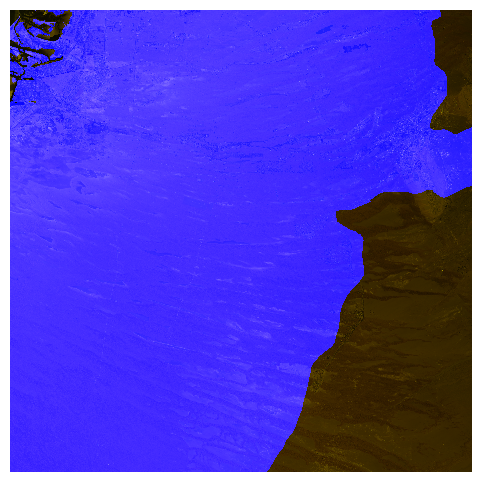

In [19]:
fig, ax = plt.subplots(figsize=(6,6))
ax.matshow(overlaid_image[:,:,1:])
plt.axis('off')
plt.show()